In [7]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F


In [8]:
data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')


In [9]:
data['timestamp'] = pd.to_datetime(data['Timestamp'],unit='s')
data = data.fillna(method='ffill')
data = data.sort_values('timestamp')
data.set_index('timestamp', inplace=True)
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
timestamp,,,,,,,,
2011-12-31 07:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [25]:
group = data.groupby('timestamp')
daily_price = group['Weighted_Price'].mean()
daily_price.head()

timestamp
2011-12-31 07:52:00    4.39
2011-12-31 07:53:00    4.39
2011-12-31 07:54:00    4.39
2011-12-31 07:55:00    4.39
2011-12-31 07:56:00    4.39
Name: Weighted_Price, dtype: float64

In [50]:
df_train = daily_price[1000:1800]
df_train = df_train.values.reshape(-1,1)
df_train.shape

(800, 1)

In [51]:
df_validation= daily_price[1801:2500] #80%
df_validation = df_validation.values.reshape(-1,1)
df_validation.shape


(699, 1)

In [52]:
df_test = daily_price[2501:3033]
df_test = df_test.values.reshape(-1,1)
df_test.shape

(532, 1)

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_validation)
test_arr = scaler.transform(df_test)

In [54]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [55]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [56]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

In [57]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [58]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [59]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [60]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [61]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [62]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)


Epoch 1 Train loss: 0.72. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.71s.
Epoch 2 Train loss: 0.60. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.56s.
Epoch 3 Train loss: 0.48. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.51s.
Epoch 4 Train loss: 0.35. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.50s.
Epoch 5 Train loss: 0.21. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.50s.
Epoch 6 Train loss: 0.12. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.48s.
Epoch 7 Train loss: 0.11. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.48s.
Epoch 8 Train loss: 0.10. Validation loss: 105640124495813361226307600384.00. Avg future: 0.00. Elapsed time: 0.48s.
Epoch 9 Train loss: 0.08. Validation loss: 105640124495813361226

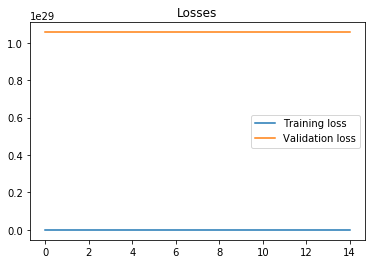

In [63]:
optimization_1.plot_losses()


Test loss 32.9352


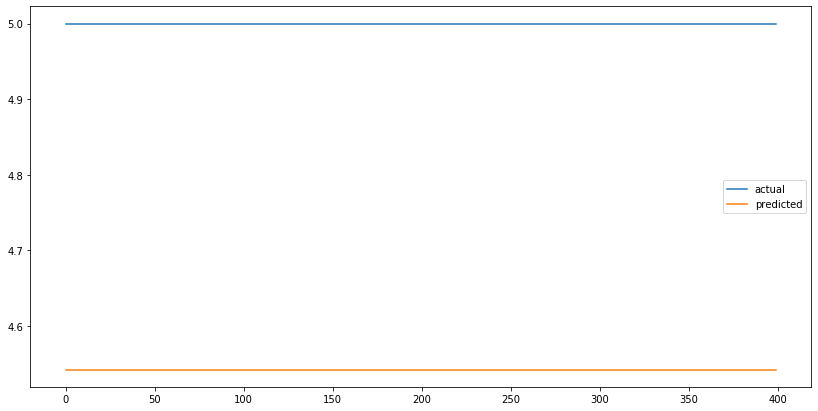

In [45]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

In [66]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.Weighted_Price[:1100] 
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

AttributeError: 'numpy.ndarray' object has no attribute 'Weighted_Price'

NameError: name 'y_sample' is not defined

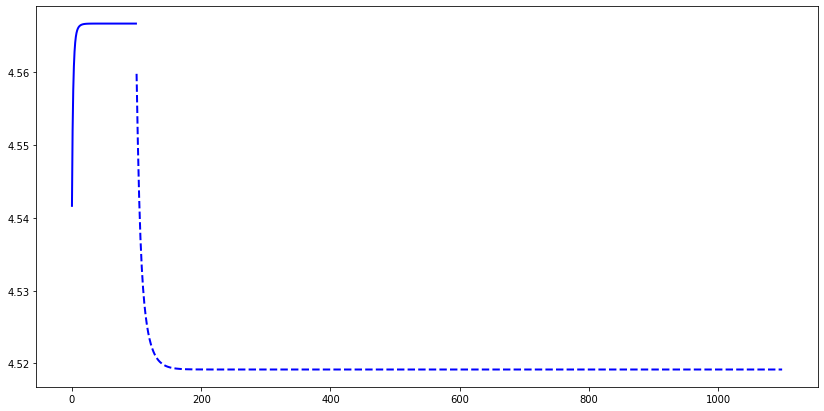

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted Price")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated Price")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual Price")
plt.legend()

TypeError: 'int' object is not callable